In [2]:
import yfinance as yf
from gurobipy import *
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

In [ ]:
stock = ["NVDA", "GOOG", "AMZN", "AAPL", "META", "TSLA"]
s = "2023-12-29"
e = "2024-12-31"


df = yf.download(stock, start=s, end=e)
daily_returns = df['Close'].pct_change().dropna() * 100
mean_return = daily_returns.mean()
cov_mat = daily_returns.cov()
print(mean_return)

df = df.drop(index=df.index[0]).reset_index(drop=True)

[*********************100%***********************]  6 of 6 completed

Ticker
AAPL    0.134503
AMZN    0.171527
GOOG    0.145771
META    0.241333
NVDA    0.474530
TSLA    0.286161
dtype: float64


In [4]:
stocks = daily_returns.columns
print(stocks)
# Create an empty model
m = Model('portfolio')
# Add a variable for each stock
vars = pd.Series(m.addVars(stocks,lb=0), index=stocks)
portfolio_risk = cov_mat.dot(vars).dot(vars)
m.setObjective(portfolio_risk, GRB.MINIMIZE)
## constraints
m.addConstr(vars.sum() == 1, 'budget')
m.addConstr(mean_return.dot(vars) >=0.25,'return')
m.optimize()
print('Minimum Risk Portfolio:\n')
for v in vars:
    if v.x > 0:
        print('\t%s\t: %g' % (v.varname, v.x))

Index(['AAPL', 'AMZN', 'GOOG', 'META', 'NVDA', 'TSLA'], dtype='object', name='Ticker')
Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13705H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 2 rows, 6 columns and 12 nonzeros
Model fingerprint: 0xfa819b6a
Model has 21 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e+00, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+00]
Presolve time: 0.02s
Presolved: 2 rows, 6 columns, 12 nonzeros
Presolved model has 21 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 5
 AA' NZ     : 2.100e+01
 Factor NZ  : 2.800e+01
 Factor Ops : 1.400e+02 (less than 1 second per iteration)
 Th


	C0	: 0.401866 - APPL
	C1	: 0.00102163 - AMZN
	C2	: 0.103756 - GOOG
	C3	: 0.193203 - META
	C4	: 0.255506 - NVDA
	C5	: 0.0446481 - TSLA

	['AAPL', 'AMZN', 'GOOG', 'META', 'NVDA', 'TSLA']

Discarded solution information


[]

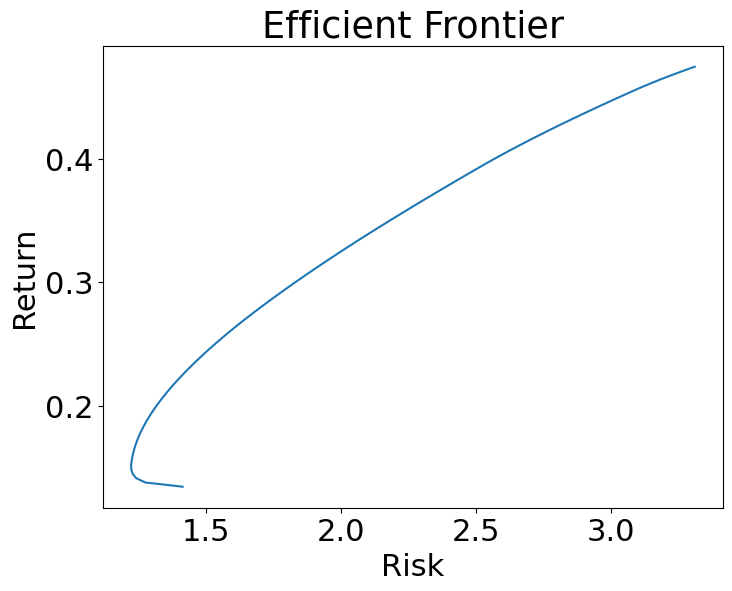

In [5]:
returns = np.linspace(mean_return.min(), mean_return.max(), 100 )
ret_list = []
risks = []
props = []
for ret in returns:
    m.reset(0)
    m = Model("Portfolio_Optimization")
    m.setParam('OutputFlag', 0)
    vars=pd.Series(m.addVars(stocks,lb=0), index=stocks)
    portfolio_risk = cov_mat.dot(vars).dot(vars)
    m.setObjective(portfolio_risk, GRB.MINIMIZE)
    m.addConstr(vars.sum() == 1, name = 'budget' )
    m.addConstr(mean_return.dot(vars) == ret , name = 'return_sim' )
    m.update()
    m.optimize()
    risks.append(np.sqrt(m.objval))
    ret_list.append(mean_return.dot(m.x) )
    props.append(m.x)
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 22})
plt.plot( risks, returns )
plt.xlabel( 'Risk' )
plt.ylabel( 'Return' )
plt.title( 'Efficient Frontier' )
plt.plot()